In [1]:
from PIL import Image
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
import pandas as pd
import pandas.util
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import math
from skimage.util import random_noise

In [2]:
def imagecrop(outsize, view):
    d = [] #Array, um die Informationen für jedes Bild zu speichern
    outsize = outsize #Bildgröße für das endgültige Bild
    outrelation = outsize[1] / outsize[0] #Verhältnis der Boxgröße festlegen
    typ = view #dorsal oder ventral?
    if view =='dorsal':
        path1 = "DIP_fresh_data/dorsal_2018/#Morph_DIP_dorsal_scale_20181124.TPS"
        path2 = "DIP_images_fresh/images dorsal_2018/"
        path3 = "out_dorsal/"
    else:
        path1 = "DIP_fresh_data/ventral_2018/#Morph_DIP_ventral_scale_20181124.TPS"
        path2 = "DIP_images_fresh/images ventral_2018/"
        path3 = "out_ventral/"
    with open(path1, "r") as f:
        for line in f:
            line = line.rstrip() #\n entfernen
            if line.startswith("LM=2"): #bei jedem LM=2 folgen neue Informationen
                d.append({}) #die relevanten Infos in einem Dictionary speichern
                d[-1]['left'] = np.array(next(f).rstrip().split(' ')).astype(np.float)
                d[-1]['right'] = np.array(next(f).rstrip().split(' ')).astype(np.float)
                d[-1]['filename'] = next(f).replace('IMAGE=','').rstrip()
    f.close()
    
    for j in range(0,len(d)):
        filename = d[j]['filename']
        file= path2+filename
        outfile = path3 +filename

        img = Image.open(file)
        left = d[j]['left']
        right =d[j]['right']

        x1 = d[j]['left'][0]
        y1 = d[j]['left'][1]
        x2 = d[j]['right'][0]
        y2 = d[j]['right'][1]

        l = np.array([x1,y1])
        r = np.array([x2,y2])
        #print(l)
        #print(r)
        angle = 0

        if (y2 != y1):

            alpha = np.arctan(np.abs(y2-y1) / np.abs(x2-x1)) #Winkel ausrechnen
            angle = alpha * 360 / (2*np.pi) #Bogenmaß in Grad umrechnen
            angle = -np.sign(y2-y1) * angle #Vorzeichen ermitteln, um richtig zu drehen
        #print(angle)
        
        phi = angle * (2*np.pi) / 360 #Grad in Bogenmaß
        O = np.array([[np.cos(phi), np.sin(phi)],[-np.sin(phi), np.cos(phi)]]) #Drehmatrix
        middle = np.array( [img.width / 2, img.height / 2] ) #rotate dreht um den Mittelpunkt

        lnew = np.dot(O,l - middle) + middle #neue Koordinaten ermitteln durch Multiplikation mit Drehmatrix und Addition der Mitte
        rnew = np.dot(O,r - middle) + middle
        img = img.rotate(angle) #rotieren mit Winkel als Grad
        
        lnew[1] = img.height-lnew[1] #auf andere Skala umrechnen mit (0,0) oben links
        rnew[1] = img.height-rnew[1]#+rnew[1]/18
        lnew[0] = lnew[0]-lnew[0]/18 #weiter zur Seite gehen
        rnew[0] = rnew[0]+rnew[0]/18
        
        width = rnew[0] - lnew[0] #Weite und Höhe für die Box ermitteln
        height = width * outrelation*(1.5)
        
        box = (lnew[0],lnew[1]-height,rnew[0],rnew[1]) #Box definieren

        cropped = img.crop(box) #Bild zuschneiden

        output = cropped.resize(outsize) #auf gewünschte Größe bringen
        output.save(outfile) #neues Bild speichern

In [3]:
imagecrop((220,200), 'dorsal')
imagecrop((220,200), 'ventral')

In [137]:
def augmentation (filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_png(img, channels = 3)
    
    img_centralcrop = tf.image.central_crop(img, central_fraction = 0.7)
    output_image = tf.image.encode_png(img_centralcrop)
    tf.io.write_file(tf.constant(filename[0:-4]+"centralcrop.jpg"), output_image)
    
    #img_flipleftright = tf.image.flip_left_right(img)
    #output_image = tf.image.encode_png(img_flipleftright)
    #tf.io.write_file(tf.constant(filename[0:-4]+"flipleftright.jpg"), output_image)
    
    img_flipupdown = tf.image.flip_up_down(img)
    output_image = tf.image.encode_png(img_flipupdown)
    tf.io.write_file(tf.constant(filename[0:-4]+"flipupdown.jpg"), output_image)
    
    img_brightness = tf.image.random_brightness(img, max_delta = 0.1)
    output_image = tf.image.encode_png(img_brightness)
    tf.io.write_file(tf.constant(filename[0:-4]+"brightness.jpg"), output_image)
    '''
    img_rotate = tf.image.rot90(img, k=2)
    output_image = tf.image.encode_png(img_rotate)
    tf.io.write_file(tf.constant(filename[0:-4]+"rotate.jpg"), output_image)
    '''
    img_saturation = tf.image.random_saturation(img, lower = 0.95, upper = 1.05)
    output_image = tf.image.encode_png(img_saturation)
    tf.io.write_file(tf.constant(filename[0:-4]+"saturation.jpg"), output_image)
    
    img_hue = tf.image.random_hue(img, max_delta = 0.02)
    output_image = tf.image.encode_png(img_hue)
    tf.io.write_file(tf.constant(filename[0:-4]+"hue.jpg"), output_image)
    
    img_gray = tf.image.rgb_to_grayscale(img)
    output_image = tf.image.encode_png(img_gray)
    tf.io.write_file(tf.constant(filename[0:-4]+"gray.jpg"), output_image)
    
    img_contrast = tf.image.adjust_contrast(img,0.6)
  #  print(img_contrast.dtype)
    #print(img_contrast.shape)
    output_image = tf.image.encode_png(img_contrast)
    tf.io.write_file(tf.constant(filename[0:-4]+"contrast.jpg"), output_image)
    
    im1 = tf.expand_dims(img,axis =0)
    im1 = tf.cast(im1, dtype = tf.float32)/255.
    img_cropresize = tf.image.crop_and_resize(im1,boxes = [[0.4, 0.0, 0.9, 0.5]], crop_size = [200,220], box_indices = [0])#bottom left
    img_cropresize = tf.squeeze(img_cropresize, [0])
    img_cropresize = tf.image.convert_image_dtype(img_cropresize, tf.uint8)
    output_image = tf.image.encode_png(img_cropresize)
    tf.io.write_file(tf.constant(filename[0:-4]+"cropresize.jpg"), output_image)
    
    im2 = tf.expand_dims(img,axis =0)
    im2 = tf.cast(im2, dtype = tf.float32)/255.
    img_cropresize2 = tf.image.crop_and_resize(im2,boxes = [[0.4, 0.5, 0.9, 1]], crop_size = [200,220], box_indices = [0]) #bottom right
    img_cropresize2 = tf.squeeze(img_cropresize2, [0])
    img_cropresize2 = tf.image.convert_image_dtype(img_cropresize2, tf.uint8)
    output_image = tf.image.encode_png(img_cropresize2)
    tf.io.write_file(tf.constant(filename[0:-4]+"cropresize2.jpg"), output_image)
    
    im3 = tf.expand_dims(img,axis =0)
    im3 = tf.cast(im3, dtype = tf.float32)/255.
    img_cropresize3 = tf.image.crop_and_resize(im3,boxes = [[0.4, 0.25, 0.9,0.75]], crop_size = [200,220], box_indices = [0]) #bottom right
    img_cropresize3 = tf.squeeze(img_cropresize3, [0])
    img_cropresize3 = tf.image.convert_image_dtype(img_cropresize2, tf.uint8)
    output_image = tf.image.encode_png(img_cropresize3)
    tf.io.write_file(tf.constant(filename[0:-4]+"cropresize3.jpg"), output_image)
    
    

In [138]:
dorsalfilelist = os.listdir("out_dorsal/")
ventralfilelist = os.listdir("out_ventral/")

f= open("images.txt","w+")
for i in range(len(ventralfilelist)):
    f.write(ventralfilelist[i][3:6]+"\t"+"ventral"+"\t"+"out_ventral/"+ventralfilelist[i]+"\n")
f.close()
f= open("images.txt","a")
for i in range(len(dorsalfilelist)):
    f.write(dorsalfilelist[i][3:6]+"\t"+"dorsal"+"\t"+"out_dorsal/"+dorsalfilelist[i]+"\n")
f.close()

In [139]:
# Create a pandas dataframe from a tab separated file 
df = pd.read_csv("images.txt", sep = '\t', names = ['classname', 'type','path'], encoding = 'unicode_escape')
print(df.head())
print("shape of data frame: ", df.shape)


  classname     type                          path
0       alp  ventral  out_ventral/DIPalp14_v_1.jpg
1       alp  ventral  out_ventral/DIPalp14_v_2.jpg
2       alp  ventral  out_ventral/DIPalp14_v_3.jpg
3       alp  ventral  out_ventral/DIPalp14_v_4.jpg
4       alp  ventral  out_ventral/DIPalp15_v_1.jpg
shape of data frame:  (666, 3)


In [140]:
for i in range(0,len(df)):
    augmentation(df["path"][i])

In [141]:
dorsalfilelist = os.listdir("out_dorsal/")
ventralfilelist = os.listdir("out_ventral/")

f= open("images.txt","w+")
for i in range(len(ventralfilelist)):
    f.write(ventralfilelist[i][3:6]+"\t"+"ventral"+"\t"+"out_ventral/"+ventralfilelist[i]+"\n")
f.close()
f= open("images.txt","a")
for i in range(len(dorsalfilelist)):
    f.write(dorsalfilelist[i][3:6]+"\t"+"dorsal"+"\t"+"out_dorsal/"+dorsalfilelist[i]+"\n")
f.close()

In [142]:
# Create a pandas dataframe from a tab separated file 
df = pd.read_csv("images.txt", sep = '\t', names = ['classname', 'type','path'], encoding = 'unicode_escape')
print(df.head())
print("shape of data frame: ", df.shape)

  classname     type                                     path
0       alp  ventral             out_ventral/DIPalp14_v_1.jpg
1       alp  ventral   out_ventral/DIPalp14_v_1brightness.jpg
2       alp  ventral  out_ventral/DIPalp14_v_1centralcrop.jpg
3       alp  ventral     out_ventral/DIPalp14_v_1contrast.jpg
4       alp  ventral   out_ventral/DIPalp14_v_1cropresize.jpg
shape of data frame:  (8658, 3)


In [143]:
# associate class names with a class (0 .. K-1)
classnames = df['classname'].unique() # all 12 species names
K = classnames.size  # 12
print(K)
name2class = dict(zip(classnames, range(K))) # dictionary that maps a name to its index in classnames array
print("names and classes:", name2class)

# Add a column 'class' to data frame  with the number representing the species name
df['class'] = df['classname'].map(name2class) # new column class with number representing plant name
# print a few random example lines
print(df.sample(n=5))

6
names and classes: {'alp': 0, 'com': 1, 'iss': 2, 'oel': 3, 'tri': 4, 'zei': 5}
     classname     type                                     path  class
816        alp  ventral           out_ventral/DIPalp5_v_4hue.jpg      0
1569       com  ventral          out_ventral/DIPcom5_v_3gray.jpg      1
8416       zei   dorsal    out_dorsal/DIPzei7_d_2cropresize2.jpg      5
4905       alp   dorsal  out_dorsal/DIPalp30_1_d_1cropresize.jpg      0
7096       iss   dorsal         out_dorsal/DIPiss8_d_5rotate.jpg      2


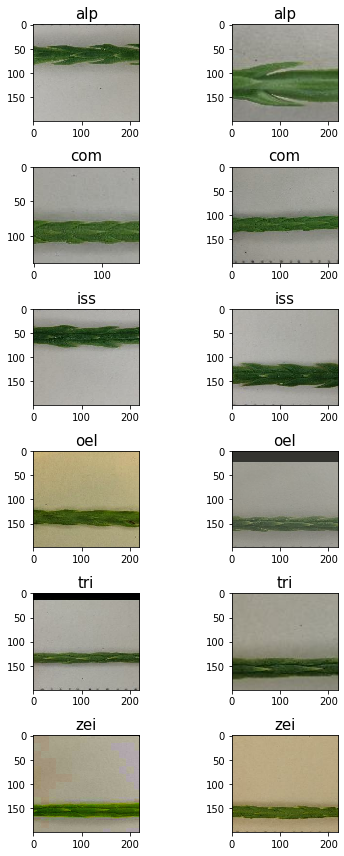

In [144]:
# Plot a few sample images for each class
examples_per_class = 2
_, ax = plt.subplots(nrows = K, ncols = examples_per_class, 
                     figsize = (3 * examples_per_class, 2 * K)) # adjust size here
for i in range(K): # loop over classes = rows
    sample = df[df['class'] == i].sample(n = examples_per_class)
    for j in range(examples_per_class):
        path = sample.iloc[j]['path']
        img = cv2.imread(path[0:])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 has color order BGR rather than RGB
        ax[i, j].imshow(img)
        ax[i, j].set_title(classnames[i], fontsize=15)  
plt.tight_layout()
plt.show()

In [145]:
# randomly split data frame into training, validation and test data frames
num_imgs  = df.shape[0] # total number of examples
num_test  = 800# size of test set, used only once at end
num_val   = 700 # size of validation set, used to monitor training progress
num_train = num_imgs - num_test - num_val # size of training set, the (large) rest

assert num_train > 0, "Error: examples consumed by test and validation sets alone"

# construct an array [0, 1, ..., num_imgs] with the indices = row numbers of df
all_idxs = np.array(range(num_imgs))
np.random.shuffle(all_idxs) # random order, so there is no bias in any partition

# construct training and testing data frames 
test_df = df.iloc[all_idxs[0 : num_test]]
val_df = df.iloc[all_idxs[num_test : num_test + num_val]]
train_df = df.iloc[all_idxs[num_test + num_val :]] # the rest

#assert train_df.shape[0] == num_train, "Internal error of 3-way split into train, test, val"
print("Sizes: train =", num_train, "\tvalidation =", num_val, "\ttest =", num_test)

Sizes: train = 7158 	validation = 700 	test = 800


In [30]:
img_size = 96    # width and height of all images (resize, if required)
batch_size = 32  # for training and prediction

In [31]:
"""
def path_to_array(filename, label):
    """ Map a filename to an actual image tensor using image augmentation, one-hot encode label."""
    img = tf.io.read_file(filename)
    img = tf.image.decode_png(img, channels = 3)
    # now img is 3 dim array of numbers in {0,..., 255}
    img = tf.cast(img, dtype = tf.float32) / 255. # scale to floating point number in [0,1]
    
    # resize to fixed input size
    img = tf.image.resize(img, [img_size, img_size])
    
    # image augmentation, make one of 8 congruent or mirrored images
    img = tf.image.random_flip_left_right(img) # 50% chance to mirror vertically
    num_rot = np.random.randint(0, 4) # rotate 0-3 times counter-clockwise by a 90 degrees  
    #img = tf.where(label >= num_animals, # assume that plants photos are bird's-eye view and may be rotated
                   #tf.image.rot90(img, k = num_rot),
                   #img)
    

    # randomly change colors
    img = tf.image.random_brightness(img, max_delta = 0.1)
    img = tf.image.random_hue(img, max_delta = 0.02)
    img = tf.image.random_saturation(img, lower = 0.95, upper = 1.05)
    
    # one-hot encode the label, e.g. 3 becomes [0,0,0,1,0,0,0,0,0,0,0,0]
    label = tf.one_hot(label, depth = K)
    return img, label
"""

In [32]:
def make_dataset(df):
    """ Make a tf dataset of images from a pd data frame of file paths """

    # first, make dataset with just the relevant: path and class
    ds_path = tf.data.Dataset.from_tensor_slices((df['path'], df['class']))

    # convert to data set with actual images
    ds = ds_path.map(path_to_array)
    ds = ds.batch(batch_size)
    return ds

test_ds  = make_dataset(test_df)
val_ds   = make_dataset(val_df)
train_ds = make_dataset(train_df)
train_ds = train_ds.repeat() # infinitely repeat

data frame:
 classname                                      com
type                                        dorsal
path         out_dorsal/DIPcom3_d_1centralcrop.jpg
class                                            1
Name: 5735, dtype: object

data set:
x: tf.Tensor(
[[[0.5640321  0.54929256 0.46365178]
  [0.56129515 0.5465557  0.46091485]
  [0.56129515 0.5465557  0.46091485]
  ...
  [0.63572323 0.6209837  0.53534293]
  [0.6310638  0.6163243  0.5306835 ]
  [0.61766773 0.6029282  0.51728743]]

 [[0.5594544  0.5450085  0.45355314]
  [0.55859905 0.54415315 0.45269787]
  [0.56129515 0.54684925 0.45539397]
  ...
  [0.62367517 0.6089357  0.52329487]
  [0.62345046 0.608711   0.52307016]
  [0.61840814 0.60366863 0.51802784]]

 [[0.56169426 0.54738176 0.45328355]
  [0.56129515 0.54698265 0.45288444]
  [0.5573736  0.5430611  0.44896287]
  ...
  [0.6206906  0.6059511  0.5203103 ]
  [0.62461215 0.6098727  0.52423185]
  [0.62461215 0.6098727  0.52423185]]

 ...

 [[0.5502845  0.5321703  0.43785852]

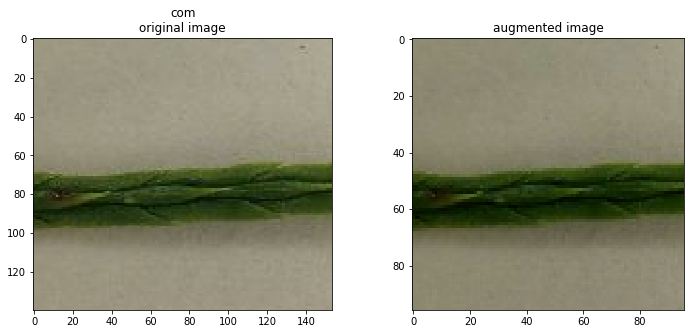

In [33]:
'''
# print and display first example from first batch
for (x, y) in train_ds.take(1):
    print("data frame:\n", train_df.iloc[0])
    print("\ndata set:")
    print("x:", x[0], "\ny: ", y[0])
    _, ax = plt.subplots(ncols = 2, figsize = (12, 5))
    
    # plot original image as on drive
    path = train_df.iloc[0]['path']
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    ax[0].imshow(img)
    ax[0].set_title(classnames[np.argmax(y[0])] + "\noriginal image")
    
    # plot augmented image
    ax[1].imshow(x[0])
    ax[1].set_title("augmented image")
'''

In [34]:
np.random.seed(1) # so we all get the same pseudorandom results

kernel_size = (3, 3)
pool_size   = (2, 2)
first_filters  = 32
second_filters = 64
third_filters  = 128
dropout_conv  = 0.3
dropout_dense = 0.3

model = tf.keras.models.Sequential() # sequential stack of layers

model.add( BatchNormalization(input_shape = (img_size, img_size, 3)))
model.add( Conv2D (first_filters, kernel_size, activation = 'relu'))
model.add( Conv2D (first_filters, kernel_size, activation = 'relu'))
model.add( Conv2D (first_filters, kernel_size, activation = 'relu'))
model.add( MaxPooling2D (pool_size = pool_size)) 
model.add( Dropout (dropout_conv))

model.add( Conv2D (second_filters, kernel_size, activation ='relu'))
model.add( Conv2D (second_filters, kernel_size, activation ='relu'))
model.add( Conv2D (second_filters, kernel_size, activation ='relu'))
model.add( MaxPooling2D (pool_size = pool_size))
model.add( Dropout (dropout_conv))

model.add( Conv2D (third_filters, kernel_size, activation ='relu'))
model.add( Conv2D (third_filters, kernel_size, activation ='relu'))
model.add( Conv2D (third_filters, kernel_size, activation ='relu'))
model.add( MaxPooling2D (pool_size = pool_size))
model.add( Dropout (dropout_conv))

model.add( Flatten())
model.add( Dense (256, activation = "relu", kernel_regularizer = tf.keras.regularizers.l2(0.001)))
model.add( Dropout (dropout_dense))
model.add( Dense (K, activation = "softmax"))

model.summary()
# draw an image with the layers
# tf.keras.utils.plot_model(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 96, 96, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 64)        1

In [36]:
# define the loss, optimization algorithm and prepare the model for gradient computation 
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005),
              loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [40]:
# Callbacks: What should be done during (long) training?
modelfname = "seeds.h5"
# Function to store model to file, if validation loss has a new record
# Check always after having seen at least another save_freq examples.
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    modelfname, monitor = 'val_loss', mode = 'min', 
    save_best_only = True, verbose = 1)

# Function to decrease learning rate by 'factor'
# when there has been no significant improvement in the last 'patience' epochs.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', mode = 'min', factor = 0.75, patience = 4, verbose = 1)
                         
# fit_generator is like fit, but training set generation (image reading) is run in parallel to optimization
history = model.fit_generator(
    train_ds, epochs = 10, 
    steps_per_epoch = 100, #would use each example once on average
    validation_data = val_ds, verbose = 1,
    callbacks = [checkpoint, reduce_lr])

Epoch 1/10
 99/100 [============================>.] - ETA: 6s - loss: 1.1133 - accuracy: 0.6338 
Epoch 00001: val_loss improved from inf to 2.60302, saving model to seeds.h5
100/100 [==============================] - 648s 6s/step - loss: 1.1085 - accuracy: 0.6355 - val_loss: 2.6030 - val_accuracy: 0.3500
Epoch 2/10
 99/100 [============================>.] - ETA: 6s - loss: 0.4444 - accuracy: 0.8886 
Epoch 00002: val_loss did not improve from 2.60302
100/100 [==============================] - 683s 7s/step - loss: 0.4434 - accuracy: 0.8888 - val_loss: 3.5865 - val_accuracy: 0.4800
Epoch 3/10
 99/100 [============================>.] - ETA: 6s - loss: 0.2811 - accuracy: 0.9569 
Epoch 00003: val_loss did not improve from 2.60302
100/100 [==============================] - 629s 6s/step - loss: 0.2801 - accuracy: 0.9572 - val_loss: 3.9789 - val_accuracy: 0.5200
Epoch 4/10
 99/100 [============================>.] - ETA: 6s - loss: 0.2342 - accuracy: 0.9726 
Epoch 00004: val_loss did not improve

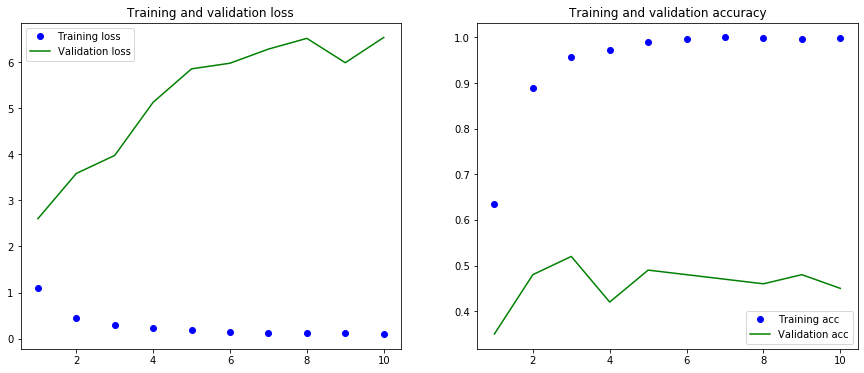

In [41]:
# plot the training history as loss and accuracy curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

_, ax = plt.subplots(ncols = 2, figsize = (15, 6))
ax[0].plot(epochs, loss, 'bo', label = 'Training loss')
ax[0].plot(epochs, val_loss, 'g', label = 'Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].legend()

ax[1].plot(epochs, acc, 'bo', label = 'Training acc')
ax[1].plot(epochs, val_acc, 'g', label = 'Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].legend();

In [42]:
# Load the parameters with the best validation accuracy during training.
# This works also if you interruped the training!
model.load_weights(modelfname)

test_loss, test_acc = model.evaluate(test_ds, verbose = 0)
print("Loss on test set:", test_loss, "\nAccuracy on test set:", test_acc)

Loss on test set: 2.3562153577804565 
Accuracy on test set: 0.39333335
